# Chapter 7 Exercises

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Apply the ARIMA(p,d,q) model on Widget Sales

In [4]:
df1 = pd.read_csv('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/widget_sales.csv')
df1.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   widget_sales  500 non-null    float64
dtypes: float64(1)
memory usage: 4.0 KB


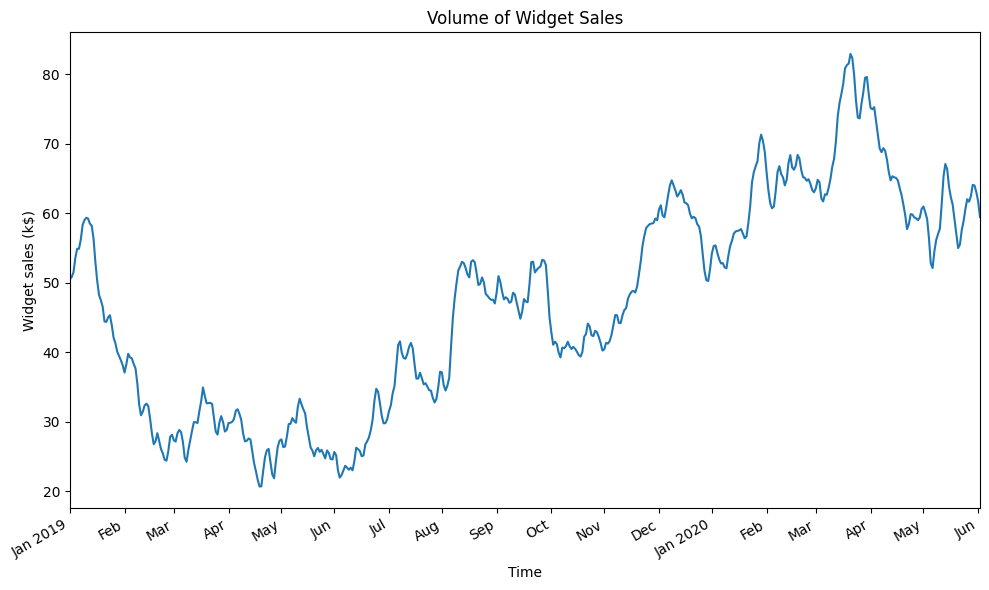

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df1['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')
plt.title('Volume of Widget Sales')
ax.set_xlim(0, 499)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate() 
plt.tight_layout()

#### ADF Test

In [8]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df1['widget_sales'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -1.5121662069359039
p-value: 0.527484535227261

p-value > alpha; H0: Not Stationary


    The series is not stationary, so let's apply differencing.

In [10]:
# First-Order differencing
eps_diff1 = np.diff(df1['widget_sales'], n=1)

ad_fuller_result1 = adfuller(eps_diff1)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -10.576657780341963
p-value: 7.07692281858714e-19

p-value < alpha; Ha: Stationary


    The series is stationary. Therefore, we can set d = 1.

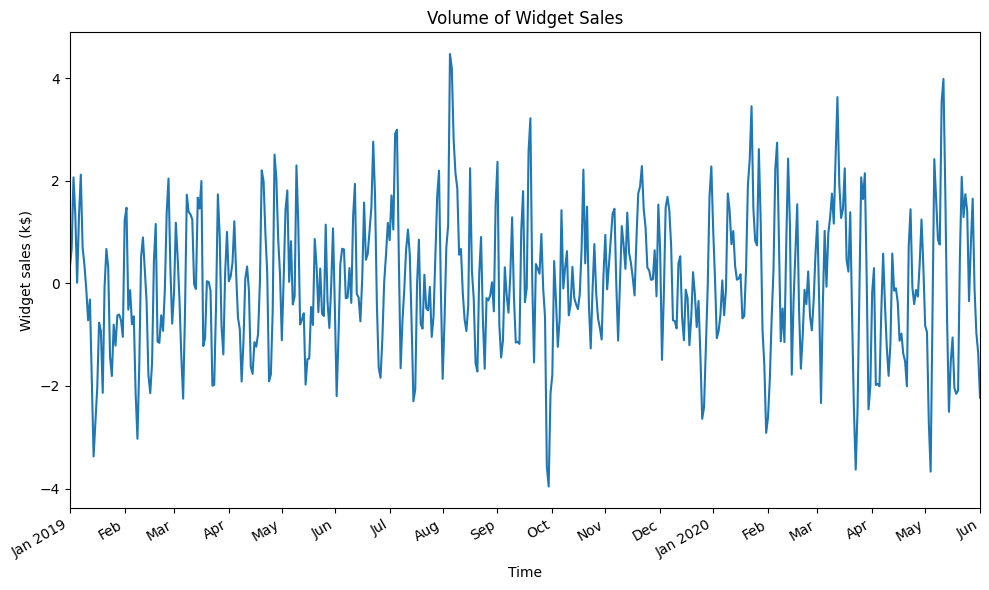

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(eps_diff1)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')
plt.title('Volume of Widget Sales')
ax.set_xlim(0, 498)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate() 
plt.tight_layout()

#### Split data in train and test

In [14]:
train = df1[:-50]  # All less the 50 last points
test = df1[-50:]   # The last 50 points

print(len(train))
print(len(test))

450
50


#### Define a range of values for p and q, and generate all unique combinations of orders (p,q)

In [16]:
from typing import Union

# The function takes as inputs the time series data and the list of unique (p,d,q) combinations
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try:        # Fit an ARMA(p,d,q) model using SARIMAX
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False) 
        except:
            continue
            
        aic = model.aic                   # Calculate the model’s AIC.
        results.append([order, aic])      # Append the (p,q) combination and AIC as a tuple to the results list
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [17]:
ps = range(0, 4, 1)                 # The order p can have the values {0,1,2,3}
qs = range(0, 4, 1)                 # The order q can have the values {0,1,2,3}
d = 1                               # Number of derivatives until Stationy

order_list = list(product(ps, qs))  # Generate the unique (p,q) combinations
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

#### Fit all unique ARIMA(p,d,q) models to extract the AIC values

In [19]:
# Fit all unique ARIMA(p,d,q) models to extract the AIC values
result_df1 = optimize_ARIMA(train, order_list, d)
result_df1

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 3)",1251.434345
1,"(0, 2)",1254.409302
2,"(2, 1)",1254.961827
3,"(0, 3)",1255.826822
4,"(3, 0)",1255.967595
5,"(1, 2)",1255.982548
6,"(1, 1)",1256.284513
7,"(3, 1)",1256.850863
8,"(2, 2)",1256.918179
9,"(1, 3)",1257.643258


#### Fit Best Model

In [21]:
# Define a SARIMAX model with specified AR(3), I(1), MA(3) parameters
model1 = SARIMAX(train, order=(3,1,3), simple_differencing=False)

# Fit the model
model_fit1 = model1.fit(disp=False)

# Display the summary
model_fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           widget_sales   No. Observations:                  450
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -618.717
Date:                Fri, 14 Feb 2025   AIC                           1251.434
Time:                        13:59:52   BIC                           1280.184
Sample:                             0   HQIC                          1262.766
                                - 450                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3632      0.064     21.169      0.000       1.237       1.489
ar.L2         -1.3529      0.065    -20.822      0.000      -1.480      -1.226
ar.L3          0.3511      0.064      5.458      0.000       0.225       0.477
ma.L1         -0.5125      0.059     -8.695      0.000      -0.628      -0.397
ma.L2          0.4679      0.059      7.905      0.000       0.352       0.584
ma.L3          0.5087      0.059      8.569      0.000       0.392       0.625
sigma2         0.9143      0.064     14.303      0.000       0.789       1.040
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                 1.40
Prob(Q):                              0.86   Prob(JB):                         0.50
Heteroskedasticity (H):               1.06   Skew:                             0.13
Prob(H) (two-sided):                  0.71   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analyzing Residuals

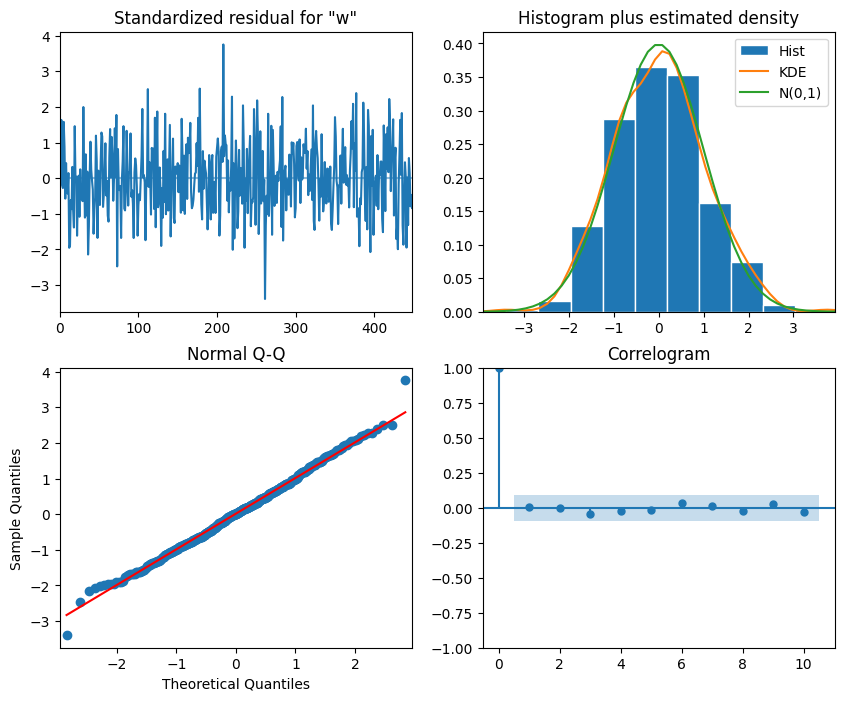

In [23]:
# Extract the residuals (errors) from the fitted model
residuals1 = model_fit1.resid 

# Diagnostic plots for the model, including residuals and other model checks
model_fit1.plot_diagnostics(figsize=(10,8));

In [24]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals1 = acorr_ljungbox(residuals1, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals1['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals1

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.017478,0.894824
2,0.045188,0.977659
3,0.241469,0.970632
4,0.263414,0.992052
5,0.283886,0.997935
6,0.704455,0.994394
7,0.828299,0.997144
8,0.902946,0.998790
9,0.952998,0.999538
10,1.003463,0.999825


#### Forecasting

In [26]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,3))  # <==== AR(3), I(1), MA(3) parameters
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [27]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df1, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df1, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df1, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

,widget_sales,pred_mean,pred_last_value,pred_ARIMA
450,64.736005,45.472231,65.906136,64.811283
451,65.316972,45.472231,65.906136,64.717886
452,65.172070,45.558754,65.316972,66.242177
453,65.075506,45.558754,65.316972,66.608644
454,64.703173,45.644943,65.075506,64.993230


#### Quantify Error

Using an ARIMA model, we get predictions in the same scale as the orginal data. Therefore, we can go straight to evaluating the model using the mean absolute error (MAE) 

In [30]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE for each forecast
mean_mae = mean_absolute_error(test['widget_sales'], test['pred_mean'])
last_mae = mean_absolute_error(test['widget_sales'], test['pred_last_value'])
ARIMA_mae = mean_absolute_error(test['widget_sales'], test['pred_ARIMA'])

# Display MSE results
print(f' MAE for Mean Forecast: {mean_mae:.2f}')
print(f' MAE for last Forecast: {last_mae:.2f}')
print(f'MAE for ARIMA Forecast: {ARIMA_mae:.2f}')

 MAE for Mean Forecast: 14.22
 MAE for last Forecast: 1.82
MAE for ARIMA Forecast: 1.57


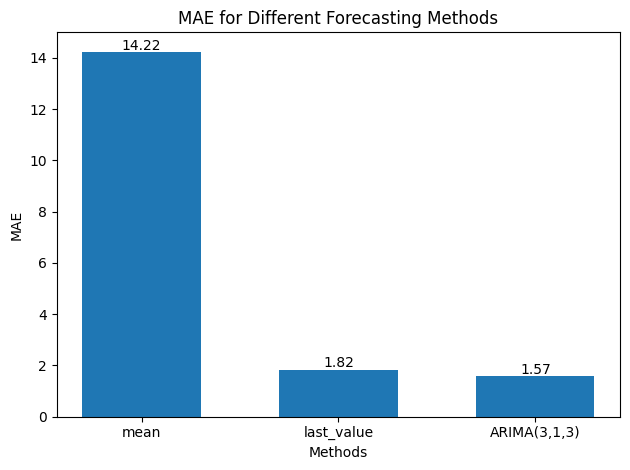

In [31]:
fig, ax = plt.subplots()

x = ['mean', 'last_value', 'ARIMA(3,1,3)']
y = [mean_mae, last_mae, ARIMA_mae]

ax.bar(x, y, width=0.6)
ax.set_xlabel('Methods')
ax.set_ylabel('MAE')
ax.set_title('MAE for Different Forecasting Methods')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(round(value, 2)), ha='center')

plt.tight_layout()

## Apply the ARIMA(p,d,q) model on Foot Traffic

In [33]:
url2 = ('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/foot_traffic.csv')

df2 = pd.read_csv(url2)

df2.head()

,foot_traffic
0,500.496714
1,500.522366
2,501.426876
3,503.295990
4,504.132695


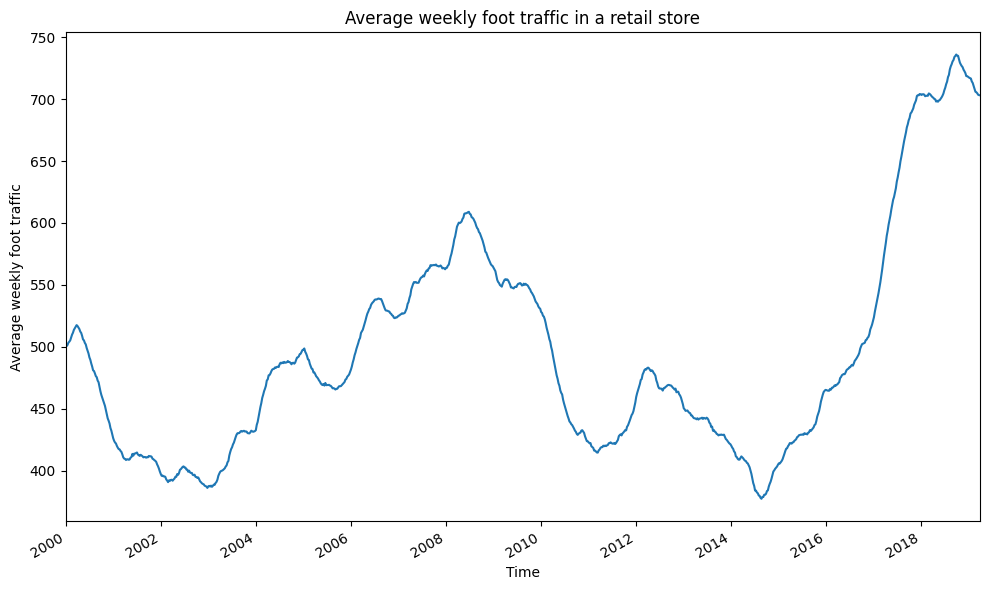

In [34]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df2['foot_traffic'])
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic')
ax.set_title('Average weekly foot traffic in a retail store')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
ax.set_xlim(0, 1000) 

fig.autofmt_xdate()
plt.tight_layout()

#### ADF Test

In [36]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df2['foot_traffic'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -1.1758885999240787
p-value: 0.6838808917896172

p-value > alpha; H0: Not Stationary


In [37]:
# First-Order differencing
eps_diff1 = np.diff(df2['foot_traffic'], n=1)

ad_fuller_result1 = adfuller(eps_diff1)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -5.2682313474220335
p-value: 6.3693176547816065e-06

p-value < alpha; Ha: Stationary


    The series is stationary. Therefore, we can set d = 1.

#### Plot Transformation

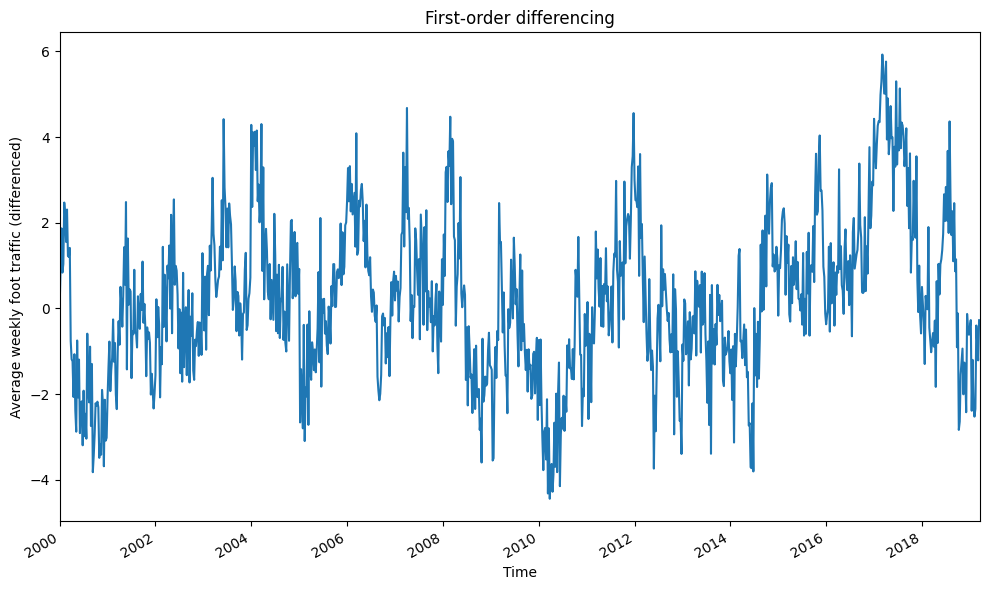

In [40]:
foot_traffic_diff = eps_diff1

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(foot_traffic_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Average weekly foot traffic (differenced)')
ax.set_title('First-order differencing')

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))
ax.set_xlim(0, 999) 

fig.autofmt_xdate()
plt.tight_layout()

#### Visualize Transformation

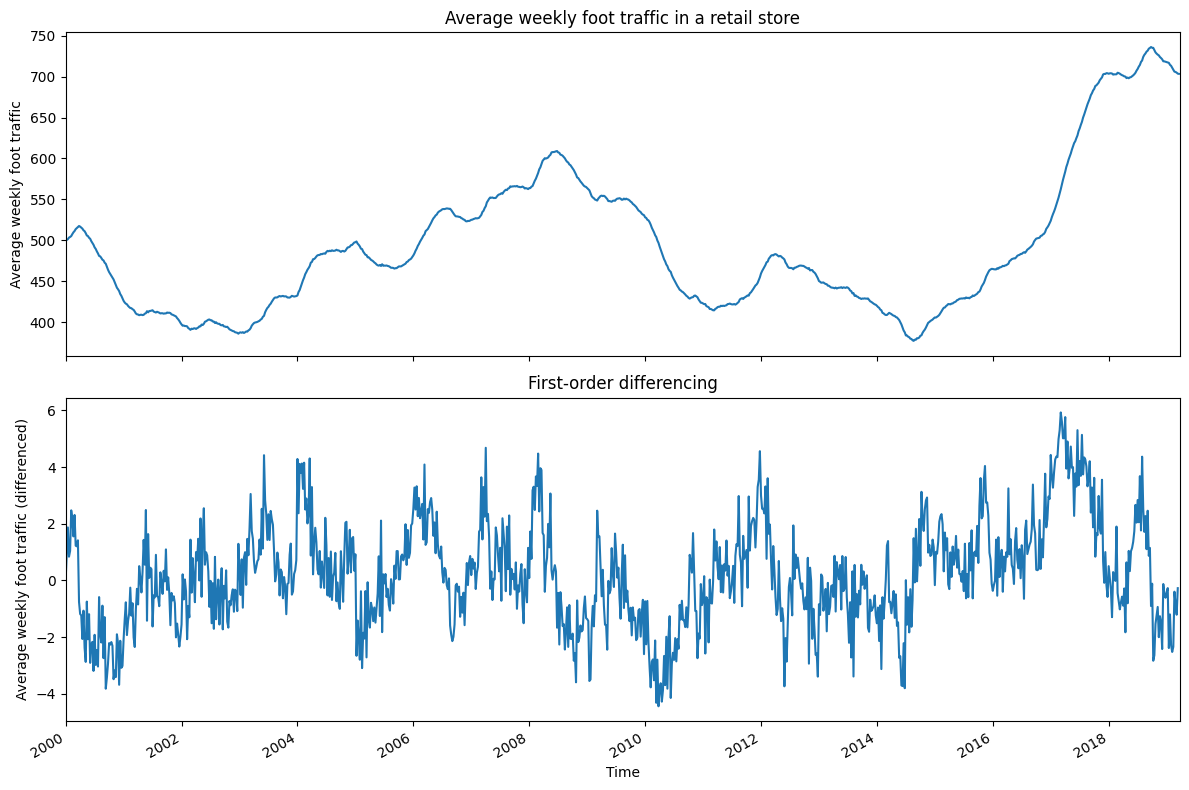

In [42]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

ax1.plot(df2['foot_traffic'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Average weekly foot traffic')
ax1.set_title('Average weekly foot traffic in a retail store')
ax1.set_xlim(0, 1000)

ax2.plot(foot_traffic_diff)
ax2.set_xlabel('Time')
ax2.set_ylabel('Average weekly foot traffic (differenced)')
ax2.set_title('First-order differencing')
ax1.set_xlim(0, 1000)

plt.xticks(np.arange(0, 1000, 104), np.arange(2000, 2020, 2))

fig.autofmt_xdate()
plt.tight_layout()

#### Split Data in Train and Test

In [44]:
train2 = df2[:-52]
test2 = df2[-52:]

print(len(train2))
print(len(test2))

948
52


#### Fit all ARIMA models. Best AIC?

In [46]:
from typing import Union

# The function takes as inputs the time series data and the list of unique (p,d,q) combinations
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try:        # Fit an ARMA(p,d,q) model using SARIMAX
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False) 
        except:
            continue
            
        aic = model.aic                   # Calculate the model’s AIC.
        results.append([order, aic])      # Append the (p,q) combination and AIC as a tuple to the results list
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [47]:
ps = range(0, 4, 1)                 # The order p can have the values {0,1,2,3}
qs = range(0, 4, 1)                 # The order q can have the values {0,1,2,3}
d = 1                               # Number of derivatives until Stationy

order_list = list(product(ps, qs))  # Generate the unique (p,q) combinations
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [48]:
# Fit all unique ARIMA(p,d,q) models to extract the AIC values
result_df2 = optimize_ARIMA(train2, order_list, d)
result_df2

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(1, 3)",2658.013441
1,"(3, 1)",2658.595081
2,"(3, 0)",2658.691777
3,"(2, 1)",2659.873751
4,"(3, 2)",2659.916852
5,"(2, 3)",2659.977855
6,"(3, 3)",2660.802094
7,"(2, 2)",2661.229924
8,"(2, 0)",2667.725827
9,"(1, 2)",2669.719835


Here, an ARIMA(1,1,3) model achieves the lowest AIC, but we can see that the top 3 models all have very similar AICs with differences in the decimal place. Notice that the third top model is an ARIMA(3,1,0).

#### Fit Best Model

In [51]:
# Define a SARIMAX model with specified AR(3), I(1), MA(0) parameters
model2 = SARIMAX(train2, order=(3,1,0), simple_differencing=False)

# Fit the model
model_fit2 = model2.fit(disp=False)

# Display the summary
model_fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           foot_traffic   No. Observations:                  948
Model:               SARIMAX(3, 1, 0)   Log Likelihood               -1325.346
Date:                Fri, 14 Feb 2025   AIC                           2658.692
Time:                        14:00:18   BIC                           2678.105
Sample:                             0   HQIC                          2666.090
                                - 948                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3165      0.033      9.603      0.000       0.252       0.381
ar.L2          0.4802      0.031     15.510      0.000       0.419       0.541
ar.L3          0.1077      0.034      3.156      0.002       0.041       0.175
sigma2         0.9603      0.043     22.180      0.000       0.875       1.045
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 3.82
Prob(Q):                              0.90   Prob(JB):                         0.15
Heteroskedasticity (H):               1.02   Skew:                             0.15
Prob(H) (two-sided):                  0.84   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analyzing Residuals

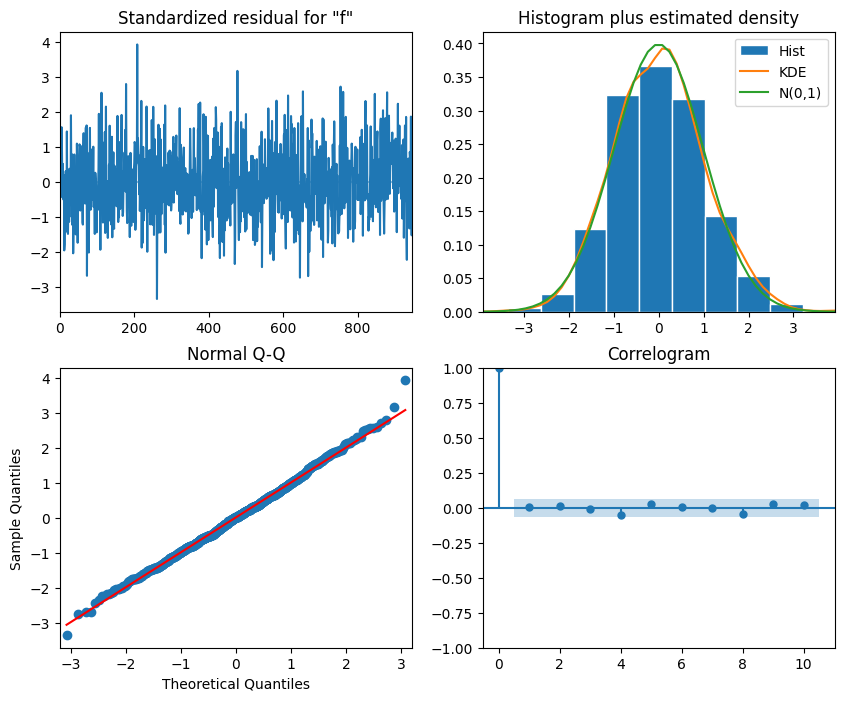

In [53]:
# Extract the residuals (errors) from the fitted model
residuals2 = model_fit2.resid 

# Diagnostic plots for the model, including residuals and other model checks
model_fit2.plot_diagnostics(figsize=(10,8));

In [54]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals2 = acorr_ljungbox(residuals2, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals2['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals2

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,5.283495e-07,0.999420
2,2.953439e-03,0.998524
3,1.120838e-02,0.999685
4,1.156744e-02,0.999983
5,1.171482e-02,0.999999
6,2.057364e-02,1.000000
7,2.283018e-02,1.000000
8,2.393564e-02,1.000000
9,2.501986e-02,1.000000
10,2.585505e-02,1.000000


#### Forecasting

In [56]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,1,0))  # <==== AR(3), I(1), MA(0) parameters
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [57]:
TRAIN_LEN = len(train2)
HORIZON = len(test2)
WINDOW = 1    # Use a window of 1, just like in chapter 5

pred_mean = rolling_forecast(df2, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df2, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df2, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test2.loc[:, 'pred_mean'] = pred_mean
test2.loc[:, 'pred_last_value'] = pred_last_value
test2.loc[:, 'pred_ARIMA'] = pred_ARIMA

test2.head()

,foot_traffic,pred_mean,pred_last_value,pred_ARIMA
948,701.686830,481.204906,702.463430,701.743717
949,701.112198,481.437237,701.686830,700.872282
950,700.221501,481.668474,701.112198,700.447460
951,699.937948,481.898288,700.221501,699.580032
952,698.107264,482.127321,699.937948,699.358669


#### Quantify Error

In [59]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE for each forecast
mean_mae = mean_absolute_error(test2['foot_traffic'], test2['pred_mean'])
last_mae = mean_absolute_error(test2['foot_traffic'], test2['pred_last_value'])
ARIMA_mae = mean_absolute_error(test2['foot_traffic'], test2['pred_ARIMA'])

# Display MSE results
print(f' MAE for Mean Forecast: {mean_mae:.2f}')
print(f' MAE for last Forecast: {last_mae:.2f}')
print(f'MAE for ARIMA Forecast: {ARIMA_mae:.2f}')

 MAE for Mean Forecast: 227.93
 MAE for last Forecast: 1.48
MAE for ARIMA Forecast: 0.75


## Apply the ARIMA(p,d,q) model on Bandwidth Dataset

In [61]:
url3 = ('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/bandwidth.csv')

df3 = pd.read_csv(url3)

df3.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


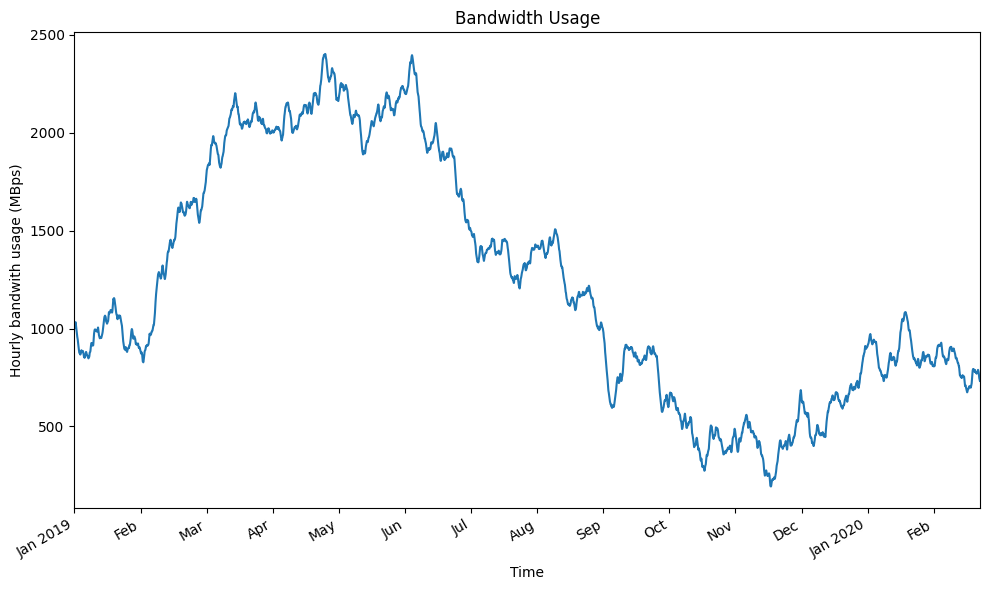

In [62]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(df3['hourly_bandwidth'])
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')
ax.set_title('Bandwidth Usage')
ax.set_xlim(0, 10000) 

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

#### ADF Test

In [64]:
# Run the Augmented Dickey-Fuller (ADF) test
adf_result = adfuller(df3['hourly_bandwidth'])

# Display ADF test result
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print()

if adf_result[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -0.8714653199451807
p-value: 0.7972240255014846

p-value > alpha; H0: Not Stationary


In [65]:
# First-Order differencing
eps_diff1 = np.diff(df3['hourly_bandwidth'], n=1)

ad_fuller_result1 = adfuller(eps_diff1)

print(f'ADF Statistic: {ad_fuller_result1[0]}')
print(f'p-value: {ad_fuller_result1[1]}')
print()

if ad_fuller_result1[1] < 0.05:
    print("p-value < alpha; Ha: Stationary")
else:
    print("p-value > alpha; H0: Not Stationary")

ADF Statistic: -20.694853863789042
p-value: 0.0

p-value < alpha; Ha: Stationary


    The series is stationary. Therefore, we can set d = 1.

#### Plot Transformation

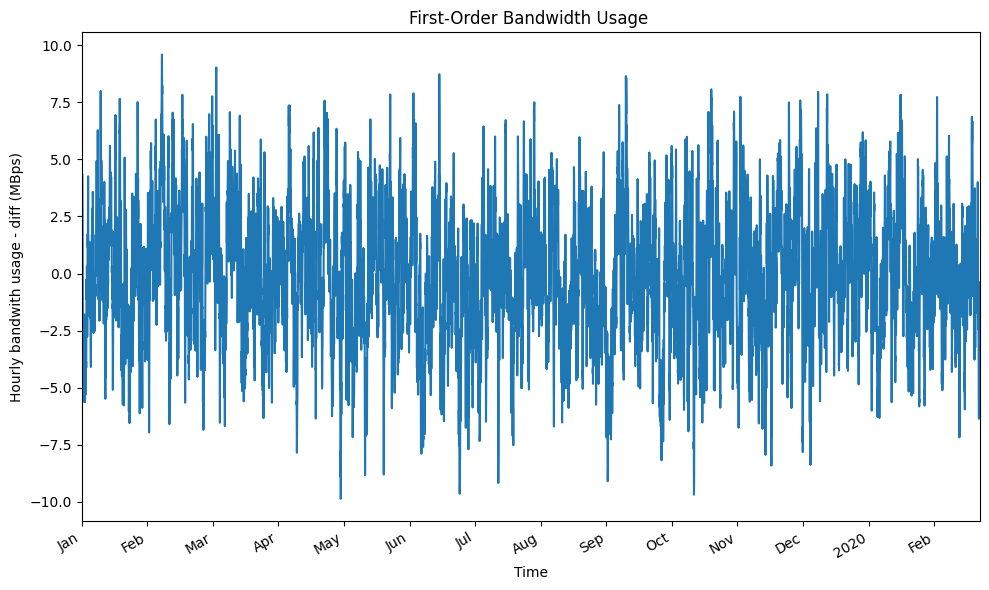

In [68]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(eps_diff1)
ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage - diff (MBps)')
ax.set_title('First-Order Bandwidth Usage ')
ax.set_xlim(0, 10000)

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

#### Visualize Transformation

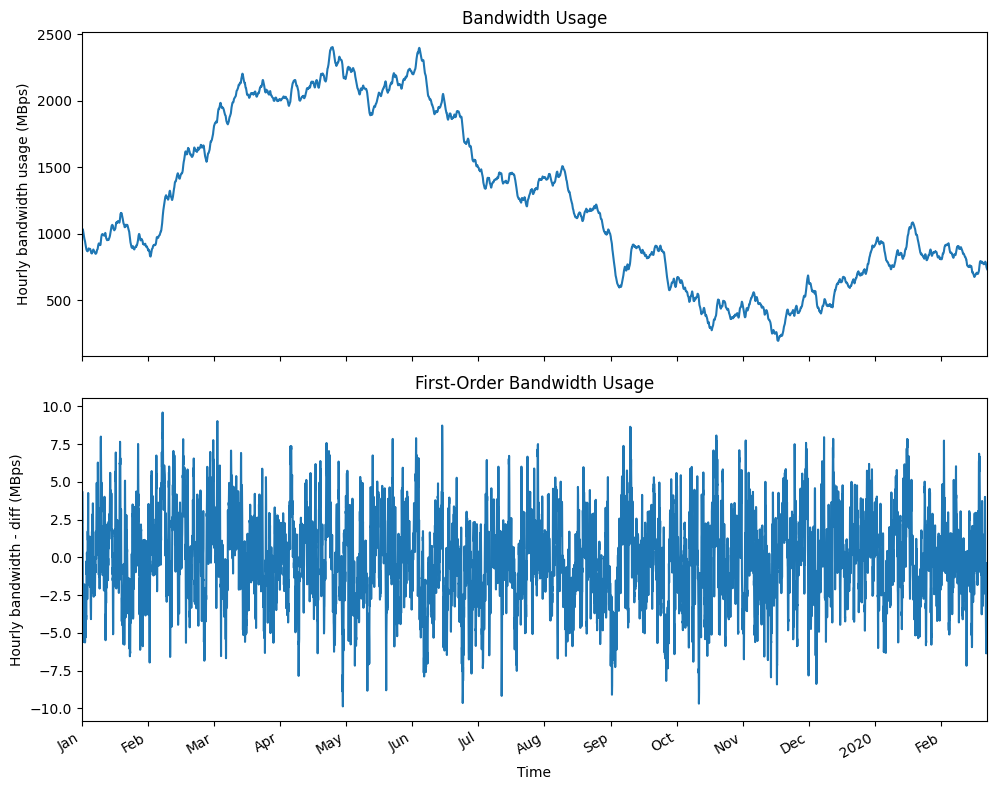

In [70]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax1.plot(df3['hourly_bandwidth'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Hourly bandwidth usage (MBps)')
ax1.set_title('Bandwidth Usage')
ax1.set_xlim(0, 10000)

ax2.plot(eps_diff1)
ax2.set_xlabel('Time')
ax2.set_ylabel('Hourly bandwidth - diff (MBps)')
ax2.set_title('First-Order Bandwidth Usage')
ax2.set_xlim(0, 10000)

plt.xticks(
    np.arange(0, 10000, 730), 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb'])

fig.autofmt_xdate()
plt.tight_layout()

#### Split data in train and test

In [72]:
train3 = df3[:-168]  # All less the 168 last points
test3 = df3[-168:]   # The last 168 points

print(len(train3))
print(len(test3))

9832
168


#### Define a range of values for p and q, and generate all unique combinations of orders (p,q)

In [74]:
from typing import Union

# The function takes as inputs the time series data and the list of unique (p,d,q) combinations
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try:        # Fit an ARMA(p,d,q) model using SARIMAX
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False) 
        except:
            continue
            
        aic = model.aic                   # Calculate the model’s AIC.
        results.append([order, aic])      # Append the (p,q) combination and AIC as a tuple to the results list
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [75]:
ps = range(0, 4, 1)                 # The order p can have the values {0,1,2,3}
qs = range(0, 4, 1)                 # The order q can have the values {0,1,2,3}
d = 1                               # Number of derivatives until Stationy

order_list = list(product(ps, qs))  # Generate the unique (p,q) combinations
order_list

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

#### Fit all unique ARIMA(p,d,q) models to extract the AIC values

In [77]:
# Fit all unique ARIMA(p,d,q) models to extract the AIC values
result_df3 = optimize_ARIMA(train3, order_list, d)
result_df3

  0%|          | 0/16 [00:00<?, ?it/s]

,"(p,q)",AIC
0,"(3, 2)",27991.063157
1,"(2, 3)",27991.286794
2,"(2, 2)",27991.602936
3,"(3, 3)",27993.416226
4,"(1, 3)",28003.348864
5,"(1, 2)",28051.350913
6,"(3, 1)",28071.155049
7,"(3, 0)",28095.617602
8,"(2, 1)",28097.250206
9,"(2, 0)",28098.407146


The ARIMA(3,1,2) model achieves the lowest AIC, but it is only slightly lower than the ARIMA(2,1,2) model.

#### Fit Best Model

In [80]:
# Define a SARIMAX model with specified AR(2), I(1), MA(2) parameters
model3 = SARIMAX(train3, order=(2,1,2), simple_differencing=False)

# Fit the model
model_fit3 = model3.fit(disp=False)

# Display the summary
model_fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:       hourly_bandwidth   No. Observations:                 9832
Model:               SARIMAX(2, 1, 2)   Log Likelihood              -13990.801
Date:                Fri, 14 Feb 2025   AIC                          27991.603
Time:                        14:00:56   BIC                          28027.569
Sample:                             0   HQIC                         28003.788
                               - 9832                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3486      0.052      6.765      0.000       0.248       0.450
ar.L2          0.4743      0.047     10.000      0.000       0.381       0.567
ma.L1          0.8667      0.050     17.249      0.000       0.768       0.965
ma.L2          0.2807      0.015     19.233      0.000       0.252       0.309
sigma2         1.0082      0.014     70.654      0.000       0.980       1.036
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                 0.50
Prob(Q):                              0.84   Prob(JB):                         0.78
Heteroskedasticity (H):               1.06   Skew:                             0.00
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Analyzing Residuals

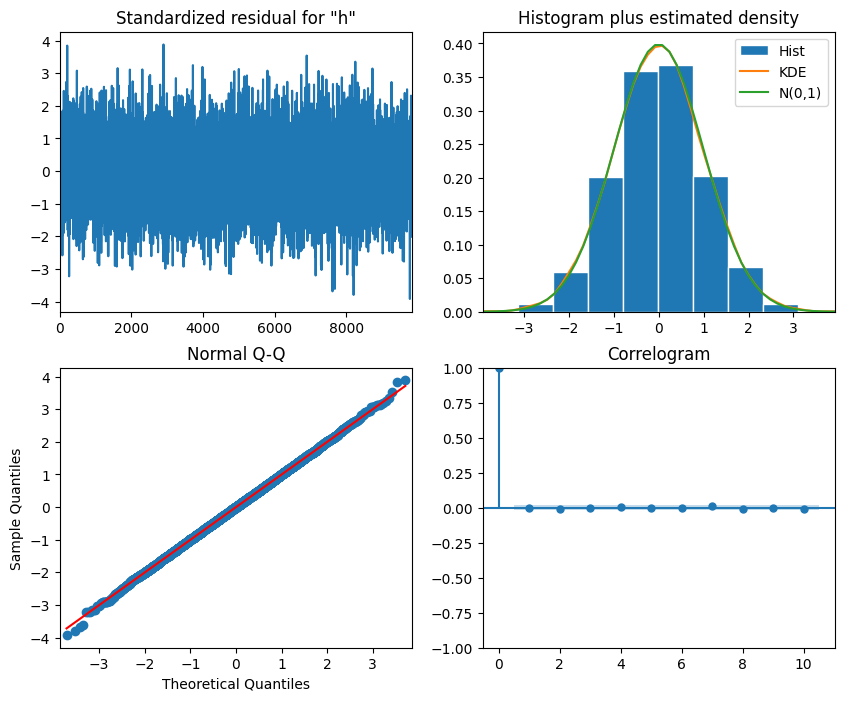

In [82]:
# Extract the residuals (errors) from the fitted model
residuals3 = model_fit3.resid 

# Diagnostic plots for the model, including residuals and other model checks
model_fit3.plot_diagnostics(figsize=(10,8));

In [83]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals3 = acorr_ljungbox(residuals3, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals3['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals3

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.001923,0.965020
2,0.005134,0.997436
3,0.025881,0.998901
4,0.025943,0.999917
5,0.026603,0.999994
6,0.049674,0.999997
7,0.057616,1.000000
8,0.060490,1.000000
9,0.063568,1.000000
10,0.065937,1.000000


#### Forecasting

In [85]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARIMA':
        pred_ARIMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,1,2))  # <==== AR(2), I(1), MA(2) parameters
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARIMA.extend(oos_pred)
            
        return pred_ARIMA

In [86]:
TRAIN_LEN = len(train3)
HORIZON = len(test3)
WINDOW = 2    # Minimum (q)

pred_mean = rolling_forecast(df3, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df3, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARIMA = rolling_forecast(df3, TRAIN_LEN, HORIZON, WINDOW, 'ARIMA')

test3.loc[:, 'pred_mean'] = pred_mean
test3.loc[:, 'pred_last_value'] = pred_last_value
test3.loc[:, 'pred_ARIMA'] = pred_ARIMA

test3.head()

,hourly_bandwidth,pred_mean,pred_last_value,pred_ARIMA
9832,717.176939,1241.072644,723.120934,717.660272
9833,711.311745,1241.072644,723.120934,712.769646
9834,708.114679,1240.965500,711.311745,705.975840
9835,707.024482,1240.965500,711.311745,701.224109
9836,707.689774,1240.857042,707.024482,706.648886


#### Quantify Error

In [88]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE for each forecast
mean_mae = mean_absolute_error(test3['hourly_bandwidth'], test3['pred_mean'])
last_mae = mean_absolute_error(test3['hourly_bandwidth'], test3['pred_last_value'])
ARIMA_mae = mean_absolute_error(test3['hourly_bandwidth'], test3['pred_ARIMA'])

# Display MSE results
print(f' MAE for Mean Forecast: {mean_mae:.2f}')
print(f' MAE for last Forecast: {last_mae:.2f}')
print(f'MAE for ARIMA Forecast: {ARIMA_mae:.2f}')

 MAE for Mean Forecast: 497.93
 MAE for last Forecast: 2.84
MAE for ARIMA Forecast: 1.38


Again, the ARIMA(2,1,2) achieves the best performance since it has the lowest MAE.